# ECE 276C HW3 P2
Mingwei Xu A53270271

In [1]:
import time
import pickle
import gym
import pybulletgym.envs
import numpy as np
from matplotlib import pyplot as plt

import torch
from torch import nn, optim
from torch.distributions import MultivariateNormal

## Setup CUDA

In [2]:
# setup device
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device('cpu')    # CPU seems faster in this question
print('Using device :', device)

if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))

Using device : cpu


## Define Network

In [3]:
class PolicyNetwork(nn.Module):
    """
    Policy Network using MLP
    """
    def __init__(self, env):
        """
        :param env: object, gym environment
        """
        super(PolicyNetwork, self).__init__()
        # get state space and action space dimension
        self.state_space_n = env.observation_space.shape[0] - 1   # should be 8 (TODO: bug in env showing wrong observation space?)
        self.action_space_n = env.action_space.shape[0]   # should be 2

        # define layers
        self.l1 = nn.Linear(self.state_space_n, 128)
        self.l2 = nn.Linear(128, 64)
        self.l3 = nn.Linear(64, self.action_space_n)

#         self.sigma = nn.Parameter(torch.eye(2))     # initalize cov matrix with grad fn
        self.sigma = nn.Parameter(torch.diag(torch.FloatTensor([0.2, 0.2])))

    def forward(self, x):
        """
        Feed forward
        
        :param x: np array, state
        :return: tensor, softmax probability of action
        """
        # TODO: take sigma as input
        # build neural network
        network = nn.Sequential(
            self.l1,
            nn.Tanh(),
            self.l2,
            nn.Tanh(),
            self.l3,
            nn.Tanh())

        return network(torch.FloatTensor(x).to(device))

## Choose Action

In [4]:
def choose_action(policy_network, state, eval_policy=False):
    """
    Choose action according to policy on given state

    :param policy_network: object, policy network
    :param state: np array, state
    :param eval_policy: bool, flag to turn on when evaluating policy.
                        It will disable sample and return action directly from policy network output.
    :returns: list (len=2), action; tensor with grad fn, log probability
    """
    probs = policy_network.forward(state)   # mean from policy network output

    cov = torch.abs(policy_network.sigma) + 1e-3    # positive definite

    m = MultivariateNormal(probs, cov)
    action = m.sample()
    log_prob = m.log_prob(action)
    
    if eval_policy:
        print('action: ', probs)
        return probs.tolist(), log_prob

    return action.tolist(), log_prob

## Question 2

In [23]:
def reinforce_with_baseline(env, policy_network, batch_size=500, num_episodes=200, lr=0.01, gamma=0.99, enable_baseline=False):
    """
    Policy gradient training using modified reinforce method with baseline

    :param env: object, gym environment
    :param policy_network: object, policy network
    :param batch_size: int, batch size
    :param num_episodes: int, number of episodes
    :param lr: float, learning rate
    :param gamma: float (0~1), discount factor
    :param enable_baseline: bool, flag to enable baseline, defaults to False
    :return: list of average reward on each episode
    """
    # setup place holders
    average_reward_list = []  # store step over episode
    average_step_list = []

    # define optimizer
#     optimizer = optim.Adam(policy_network.parameters(), 
#                            lr=lr)
    optimizer = optim.SGD(policy_network.parameters(), 
                           lr=lr)

    # train
    for i in range(num_episodes):
        # setup placeholders for each batch
        batch_loss_sum = 0
        batch_traj_counter = 0
        batch_rewards = []
        batch_log_prob_list = []
        batch_discounted_return_list = []
        batch_traj_steps = []

        # setup placeholders for each trajectory
        traj_rewards = []
        traj_log_prob_list = []
        traj_step_counter = 0

        # reset environment
        state = env.reset()
        done = False

        # batch
        for step in range(batch_size):
            # exploration
            action, log_prob = choose_action(policy_network, state)
            state_next, reward, done, _ = env.step(action)
            # env.render()

            # store data
            traj_rewards.append(reward)
            traj_log_prob_list.append(log_prob)

            # move on
            if done or (step == batch_size - 1):
                # trajectory or batch finished, update trajectory
                discounted_return_list = [sum([gamma ** (t_prime - t) * traj_rewards[t_prime] for t_prime in range(t, len(traj_rewards))]) \
                                          for t in range(1, len(traj_rewards) + 1)]

                # collect batch info
                batch_log_prob_list.extend(traj_log_prob_list)
                batch_discounted_return_list.extend(discounted_return_list)
                
                # reset state
                batch_rewards.append(np.sum(traj_rewards))
                batch_traj_counter += 1
                batch_traj_steps.append(traj_step_counter)

                traj_step_counter = 0
                traj_rewards = []
                traj_log_prob_list = []

                state = env.reset()
            else:
                state = state_next

        # finish batch
        # subtract average returns if baseline is enabled
        if enable_baseline:
            batch_discounted_return_list -= np.mean(batch_discounted_return_list)
        
        # sum the traj loss by loop so we do not lose tensor gradient
        for step in range(len(batch_log_prob_list)):
            batch_loss_sum += batch_log_prob_list[step] * batch_discounted_return_list[step]
        
        average_batch_reward = np.mean(batch_rewards)
        average_reward_list.append(average_batch_reward)
        average_step_list.append(np.mean(batch_traj_steps))
        loss = - batch_loss_sum / batch_traj_counter    # TODO
        
        print('TODO: sigma: ', policy_network.sigma)    # TODO
        print('Episode [{}/{}] loss: {:.2f}, average reward: {:.2f}, trajectory num: {}'.format(i + 1, num_episodes,
                               loss.item(), average_batch_reward, batch_traj_counter))

        # update policy
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return average_reward_list, average_step_list

### Training

In [24]:
env = gym.make('modified_gym_env:ReacherPyBulletEnv-v1', rand_init=False)
# env.render()
# TODO: test
state = env.reset()
print(state)

# setup network
policy_network = PolicyNetwork(env).to(device)
average_reward_list, average_step_list = reinforce_with_baseline(env, policy_network,batch_size=2000, num_episodes=500,
                                              lr=0.01, gamma=0.9, enable_baseline=True)

options= 
[ 0.3928371   0.3928371  -0.68091764  0.26561381  0.5         0.
  0.08333333  0.        ]
TODO: sigma:  Parameter containing:
tensor([[0.2000, 0.0000],
        [0.0000, 0.2000]], requires_grad=True)
Episode [1/500] loss: 0.37, average reward: -25.19, trajectory num: 16
TODO: sigma:  Parameter containing:
tensor([[0.2162, 0.0000],
        [0.0000, 0.2025]], requires_grad=True)
Episode [2/500] loss: -0.62, average reward: -33.90, trajectory num: 14
TODO: sigma:  Parameter containing:
tensor([[0.1984, 0.0000],
        [0.0000, 0.1911]], requires_grad=True)
Episode [3/500] loss: 0.14, average reward: -28.64, trajectory num: 17
TODO: sigma:  Parameter containing:
tensor([[0.2159, 0.0000],
        [0.0000, 0.1811]], requires_grad=True)
Episode [4/500] loss: -1.60, average reward: -33.43, trajectory num: 14
TODO: sigma:  Parameter containing:
tensor([[0.1734, 0.0000],
        [0.0000, 0.1429]], requires_grad=True)
Episode [5/500] loss: -1.77, average reward: -31.55, trajectory num:

TODO: sigma:  Parameter containing:
tensor([[ 0.0068,  0.0000],
        [ 0.0000, -0.2875]], requires_grad=True)
Episode [46/500] loss: 0.55, average reward: -10.66, trajectory num: 30
TODO: sigma:  Parameter containing:
tensor([[ 1.9379,  0.0000],
        [ 0.0000, -0.2548]], requires_grad=True)
Episode [47/500] loss: 1.66, average reward: -43.37, trajectory num: 21
TODO: sigma:  Parameter containing:
tensor([[ 1.9423,  0.0000],
        [ 0.0000, -0.2862]], requires_grad=True)
Episode [48/500] loss: -4.79, average reward: -67.57, trajectory num: 14
TODO: sigma:  Parameter containing:
tensor([[ 1.9350,  0.0000],
        [ 0.0000, -0.1684]], requires_grad=True)
Episode [49/500] loss: -4.39, average reward: -56.31, trajectory num: 15
TODO: sigma:  Parameter containing:
tensor([[ 1.9048,  0.0000],
        [ 0.0000, -0.2550]], requires_grad=True)
Episode [50/500] loss: -4.68, average reward: -71.50, trajectory num: 14
TODO: sigma:  Parameter containing:
tensor([[ 1.8895,  0.0000],
        

TODO: sigma:  Parameter containing:
tensor([[1.2486, 0.0000],
        [0.0000, 0.3412]], requires_grad=True)
Episode [91/500] loss: -0.34, average reward: -23.67, trajectory num: 24
TODO: sigma:  Parameter containing:
tensor([[1.2528, 0.0000],
        [0.0000, 0.3161]], requires_grad=True)
Episode [92/500] loss: -1.20, average reward: -35.82, trajectory num: 17
TODO: sigma:  Parameter containing:
tensor([[1.2444, 0.0000],
        [0.0000, 0.3118]], requires_grad=True)
Episode [93/500] loss: -2.29, average reward: -27.39, trajectory num: 21
TODO: sigma:  Parameter containing:
tensor([[1.2301, 0.0000],
        [0.0000, 0.2950]], requires_grad=True)
Episode [94/500] loss: -0.25, average reward: -19.52, trajectory num: 29
TODO: sigma:  Parameter containing:
tensor([[1.2196, 0.0000],
        [0.0000, 0.3303]], requires_grad=True)
Episode [95/500] loss: -8.26, average reward: -27.02, trajectory num: 21
TODO: sigma:  Parameter containing:
tensor([[1.1857, 0.0000],
        [0.0000, 0.2062]], r

TODO: sigma:  Parameter containing:
tensor([[ 0.7819,  0.0000],
        [ 0.0000, -0.3196]], requires_grad=True)
Episode [136/500] loss: -1.50, average reward: -16.08, trajectory num: 30
TODO: sigma:  Parameter containing:
tensor([[ 0.7767,  0.0000],
        [ 0.0000, -0.2853]], requires_grad=True)
Episode [137/500] loss: 0.00, average reward: -13.12, trajectory num: 37
TODO: sigma:  Parameter containing:
tensor([[ 0.7806,  0.0000],
        [ 0.0000, -0.2750]], requires_grad=True)
Episode [138/500] loss: -1.28, average reward: -15.17, trajectory num: 28
TODO: sigma:  Parameter containing:
tensor([[ 0.7754,  0.0000],
        [ 0.0000, -0.2429]], requires_grad=True)
Episode [139/500] loss: -1.77, average reward: -25.22, trajectory num: 16
TODO: sigma:  Parameter containing:
tensor([[ 0.7755,  0.0000],
        [ 0.0000, -0.1697]], requires_grad=True)
Episode [140/500] loss: -0.16, average reward: -24.65, trajectory num: 15
TODO: sigma:  Parameter containing:
tensor([[ 0.7679,  0.0000],
  

TODO: sigma:  Parameter containing:
tensor([[0.1747, 0.0000],
        [0.0000, 0.1185]], requires_grad=True)
Episode [181/500] loss: -3.60, average reward: -14.86, trajectory num: 14
TODO: sigma:  Parameter containing:
tensor([[ 0.0538,  0.0000],
        [ 0.0000, -0.0052]], requires_grad=True)
Episode [182/500] loss: -0.18, average reward: -5.44, trajectory num: 36
TODO: sigma:  Parameter containing:
tensor([[-0.0068,  0.0000],
        [ 0.0000, -0.2489]], requires_grad=True)
Episode [183/500] loss: -1.76, average reward: -9.71, trajectory num: 22
TODO: sigma:  Parameter containing:
tensor([[ 0.8214,  0.0000],
        [ 0.0000, -0.2037]], requires_grad=True)
Episode [184/500] loss: -1.37, average reward: -15.23, trajectory num: 29
TODO: sigma:  Parameter containing:
tensor([[ 0.8109,  0.0000],
        [ 0.0000, -0.1793]], requires_grad=True)
Episode [185/500] loss: -3.29, average reward: -31.34, trajectory num: 14
TODO: sigma:  Parameter containing:
tensor([[ 0.7765,  0.0000],
       

TODO: sigma:  Parameter containing:
tensor([[-0.1815,  0.0000],
        [ 0.0000, -0.7810]], requires_grad=True)
Episode [225/500] loss: -1.28, average reward: -14.99, trajectory num: 37
TODO: sigma:  Parameter containing:
tensor([[-0.1616,  0.0000],
        [ 0.0000, -0.7692]], requires_grad=True)
Episode [226/500] loss: -0.66, average reward: -13.82, trajectory num: 39
TODO: sigma:  Parameter containing:
tensor([[-0.1415,  0.0000],
        [ 0.0000, -0.7648]], requires_grad=True)
Episode [227/500] loss: -2.74, average reward: -13.18, trajectory num: 40
TODO: sigma:  Parameter containing:
tensor([[-0.1289,  0.0000],
        [ 0.0000, -0.7314]], requires_grad=True)
Episode [228/500] loss: -0.78, average reward: -11.38, trajectory num: 45
TODO: sigma:  Parameter containing:
tensor([[-0.1559,  0.0000],
        [ 0.0000, -0.7160]], requires_grad=True)
Episode [229/500] loss: -0.47, average reward: -16.19, trajectory num: 31
TODO: sigma:  Parameter containing:
tensor([[-0.2378,  0.0000],
 

TODO: sigma:  Parameter containing:
tensor([[-1.7250,  0.0000],
        [ 0.0000,  0.3506]], requires_grad=True)
Episode [269/500] loss: 0.80, average reward: -23.43, trajectory num: 33
TODO: sigma:  Parameter containing:
tensor([[-1.7251,  0.0000],
        [ 0.0000,  0.3731]], requires_grad=True)
Episode [270/500] loss: -2.85, average reward: -17.37, trajectory num: 43
TODO: sigma:  Parameter containing:
tensor([[-1.7203,  0.0000],
        [ 0.0000,  0.3191]], requires_grad=True)
Episode [271/500] loss: -1.81, average reward: -16.99, trajectory num: 45
TODO: sigma:  Parameter containing:
tensor([[-1.7187,  0.0000],
        [ 0.0000,  0.2712]], requires_grad=True)
Episode [272/500] loss: -3.19, average reward: -50.09, trajectory num: 14
TODO: sigma:  Parameter containing:
tensor([[-1.7205,  0.0000],
        [ 0.0000,  0.1423]], requires_grad=True)
Episode [273/500] loss: -2.91, average reward: -38.81, trajectory num: 16
TODO: sigma:  Parameter containing:
tensor([[-1.7023,  0.0000],
  

TODO: sigma:  Parameter containing:
tensor([[-1.4389,  0.0000],
        [ 0.0000,  1.0800]], requires_grad=True)
Episode [313/500] loss: 2.88, average reward: -69.04, trajectory num: 17
TODO: sigma:  Parameter containing:
tensor([[-1.4590,  0.0000],
        [ 0.0000,  1.0798]], requires_grad=True)
Episode [314/500] loss: 3.60, average reward: -70.87, trajectory num: 16
TODO: sigma:  Parameter containing:
tensor([[-1.4857,  0.0000],
        [ 0.0000,  1.0771]], requires_grad=True)
Episode [315/500] loss: 8.01, average reward: -72.14, trajectory num: 16
TODO: sigma:  Parameter containing:
tensor([[-1.4949,  0.0000],
        [ 0.0000,  1.1386]], requires_grad=True)
Episode [316/500] loss: -8.52, average reward: -73.04, trajectory num: 16
TODO: sigma:  Parameter containing:
tensor([[-1.4836,  0.0000],
        [ 0.0000,  1.0787]], requires_grad=True)
Episode [317/500] loss: -0.13, average reward: -71.07, trajectory num: 16
TODO: sigma:  Parameter containing:
tensor([[-1.4550,  0.0000],
    

TODO: sigma:  Parameter containing:
tensor([[-0.8706,  0.0000],
        [ 0.0000,  1.1883]], requires_grad=True)
Episode [357/500] loss: -2.74, average reward: -29.77, trajectory num: 28
TODO: sigma:  Parameter containing:
tensor([[-0.8625,  0.0000],
        [ 0.0000,  1.1713]], requires_grad=True)
Episode [358/500] loss: -0.88, average reward: -49.32, trajectory num: 16
TODO: sigma:  Parameter containing:
tensor([[-0.8519,  0.0000],
        [ 0.0000,  1.1716]], requires_grad=True)
Episode [359/500] loss: 2.54, average reward: -30.51, trajectory num: 26
TODO: sigma:  Parameter containing:
tensor([[-0.8670,  0.0000],
        [ 0.0000,  1.1823]], requires_grad=True)
Episode [360/500] loss: 0.35, average reward: -38.28, trajectory num: 20
TODO: sigma:  Parameter containing:
tensor([[-0.8836,  0.0000],
        [ 0.0000,  1.1730]], requires_grad=True)
Episode [361/500] loss: -2.28, average reward: -26.21, trajectory num: 32
TODO: sigma:  Parameter containing:
tensor([[-0.8560,  0.0000],
   

TODO: sigma:  Parameter containing:
tensor([[-0.3951,  0.0000],
        [ 0.0000,  0.8530]], requires_grad=True)
Episode [401/500] loss: -1.68, average reward: -13.69, trajectory num: 48
TODO: sigma:  Parameter containing:
tensor([[-0.3905,  0.0000],
        [ 0.0000,  0.8356]], requires_grad=True)
Episode [402/500] loss: -0.92, average reward: -11.31, trajectory num: 59
TODO: sigma:  Parameter containing:
tensor([[-0.3941,  0.0000],
        [ 0.0000,  0.8229]], requires_grad=True)
Episode [403/500] loss: -0.96, average reward: -12.20, trajectory num: 56
TODO: sigma:  Parameter containing:
tensor([[-0.4046,  0.0000],
        [ 0.0000,  0.8062]], requires_grad=True)
Episode [404/500] loss: -5.06, average reward: -25.40, trajectory num: 21
TODO: sigma:  Parameter containing:
tensor([[-0.3895,  0.0000],
        [ 0.0000,  0.7511]], requires_grad=True)
Episode [405/500] loss: -0.25, average reward: -9.95, trajectory num: 67
TODO: sigma:  Parameter containing:
tensor([[-0.3701,  0.0000],
  

TODO: sigma:  Parameter containing:
tensor([[-0.0432,  0.0000],
        [ 0.0000,  0.1718]], requires_grad=True)
Episode [445/500] loss: 0.16, average reward: -16.53, trajectory num: 14
TODO: sigma:  Parameter containing:
tensor([[-0.1355,  0.0000],
        [ 0.0000,  0.1568]], requires_grad=True)
Episode [446/500] loss: -2.20, average reward: -20.22, trajectory num: 14
TODO: sigma:  Parameter containing:
tensor([[-0.0956,  0.0000],
        [ 0.0000,  0.0510]], requires_grad=True)
Episode [447/500] loss: -0.38, average reward: -17.18, trajectory num: 14
TODO: sigma:  Parameter containing:
tensor([[-0.2200,  0.0000],
        [ 0.0000, -0.2508]], requires_grad=True)
Episode [448/500] loss: -0.71, average reward: -7.97, trajectory num: 67
TODO: sigma:  Parameter containing:
tensor([[-0.2077,  0.0000],
        [ 0.0000, -0.2333]], requires_grad=True)
Episode [449/500] loss: -1.18, average reward: -7.81, trajectory num: 67
TODO: sigma:  Parameter containing:
tensor([[-0.1505,  0.0000],
    

TODO: sigma:  Parameter containing:
tensor([[-0.4634,  0.0000],
        [ 0.0000,  1.2121]], requires_grad=True)
Episode [490/500] loss: 2.07, average reward: -56.42, trajectory num: 14
TODO: sigma:  Parameter containing:
tensor([[-0.4498,  0.0000],
        [ 0.0000,  1.2344]], requires_grad=True)
Episode [491/500] loss: 0.54, average reward: -52.41, trajectory num: 15
TODO: sigma:  Parameter containing:
tensor([[-0.3847,  0.0000],
        [ 0.0000,  1.2626]], requires_grad=True)
Episode [492/500] loss: -4.14, average reward: -54.37, trajectory num: 14
TODO: sigma:  Parameter containing:
tensor([[-0.4311,  0.0000],
        [ 0.0000,  1.2156]], requires_grad=True)
Episode [493/500] loss: -11.44, average reward: -54.85, trajectory num: 14
TODO: sigma:  Parameter containing:
tensor([[-0.3581,  0.0000],
        [ 0.0000,  1.1475]], requires_grad=True)
Episode [494/500] loss: -0.44, average reward: -52.33, trajectory num: 14
TODO: sigma:  Parameter containing:
tensor([[-0.3859,  0.0000],
  

### Plot

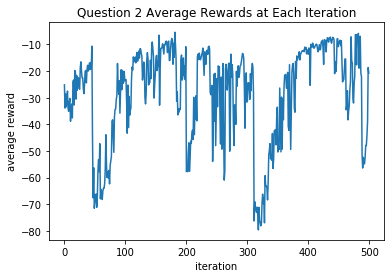

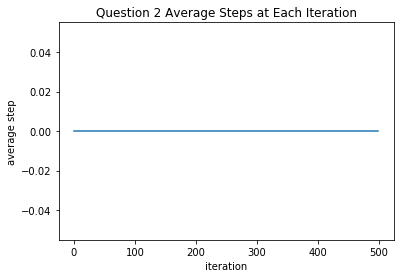

In [25]:
%matplotlib inline
plt.figure()
plt.plot(average_reward_list)
plt.xlabel('iteration')
plt.ylabel('average reward')
plt.title('Question 2 Average Rewards at Each Iteration')
plt.savefig('Question_2.png')
plt.show()

plt.figure()
plt.plot(average_step_list)
plt.xlabel('iteration')
plt.ylabel('average step')
plt.title('Question 2 Average Steps at Each Iteration')
plt.savefig('Question_2.png')
plt.show()

### Save Policy

In [26]:
with open('p2_policy.pkl', 'wb') as pickle_file:
    pickle.dump(policy_network, pickle_file)

## Test Policy

In [5]:
# load policy
with open('p2_policy.pkl', 'rb') as pickle_file:
    policy_network = pickle.load(pickle_file)

# test policy
env = gym.make('modified_gym_env:ReacherPyBulletEnv-v1', rand_init=False)
env.render()
state = env.reset()
done = False
steps = 0
time.sleep(5)

while not done:
    # TODO: do not sample here
    action, log_prob = choose_action(policy_network, state, eval_policy=True)
    state_next, reward, done, _ = env.step(action)
    steps += 1
    state = state_next
    time.sleep(0.1)

print('Finished in {} steps'.format(steps))

current_dir=/Users/xumw1996/anaconda3/lib/python3.7/site-packages/pybullet_envs/bullet
options= 
action:  tensor([-1.0000, -1.0000], grad_fn=<TanhBackward>)
action:  tensor([-1.0000, -0.9999], grad_fn=<TanhBackward>)
action:  tensor([-1.0000, -0.9992], grad_fn=<TanhBackward>)
action:  tensor([-1.0000, -0.9764], grad_fn=<TanhBackward>)
action:  tensor([-1.0000, -0.0418], grad_fn=<TanhBackward>)
action:  tensor([-1.0000,  0.6780], grad_fn=<TanhBackward>)
action:  tensor([-1.0000,  0.3195], grad_fn=<TanhBackward>)
action:  tensor([-0.9920,  0.2254], grad_fn=<TanhBackward>)
action:  tensor([0.7718, 0.0472], grad_fn=<TanhBackward>)
action:  tensor([-0.0984,  0.7375], grad_fn=<TanhBackward>)
action:  tensor([ 0.9911, -0.3658], grad_fn=<TanhBackward>)
action:  tensor([-0.2056,  0.8954], grad_fn=<TanhBackward>)
action:  tensor([ 0.9967, -0.4595], grad_fn=<TanhBackward>)
action:  tensor([0.0110, 0.8948], grad_fn=<TanhBackward>)
action:  tensor([ 0.9917, -0.4209], grad_fn=<TanhBackward>)
action: